In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.getcwd())

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

# Synthetic data

In [2]:
from BigGAN.gan_load import make_big_gan
from utils.utils import to_image
from gan_mask_gen import MaskGenerator, MaskSynthesizing
from train_segmentation import SegmentationTrainParams
from visualization import draw_with_mask
from postprocessing import connected_components_filter
%matplotlib inline

G = make_big_gan('BigGAN/weights/BigBiGAN_x1.pth').cuda().eval()
bg_direction = torch.load('BigGAN/weights/bg_direction.pth').cuda()

Adding attention layer in G at resolution 64


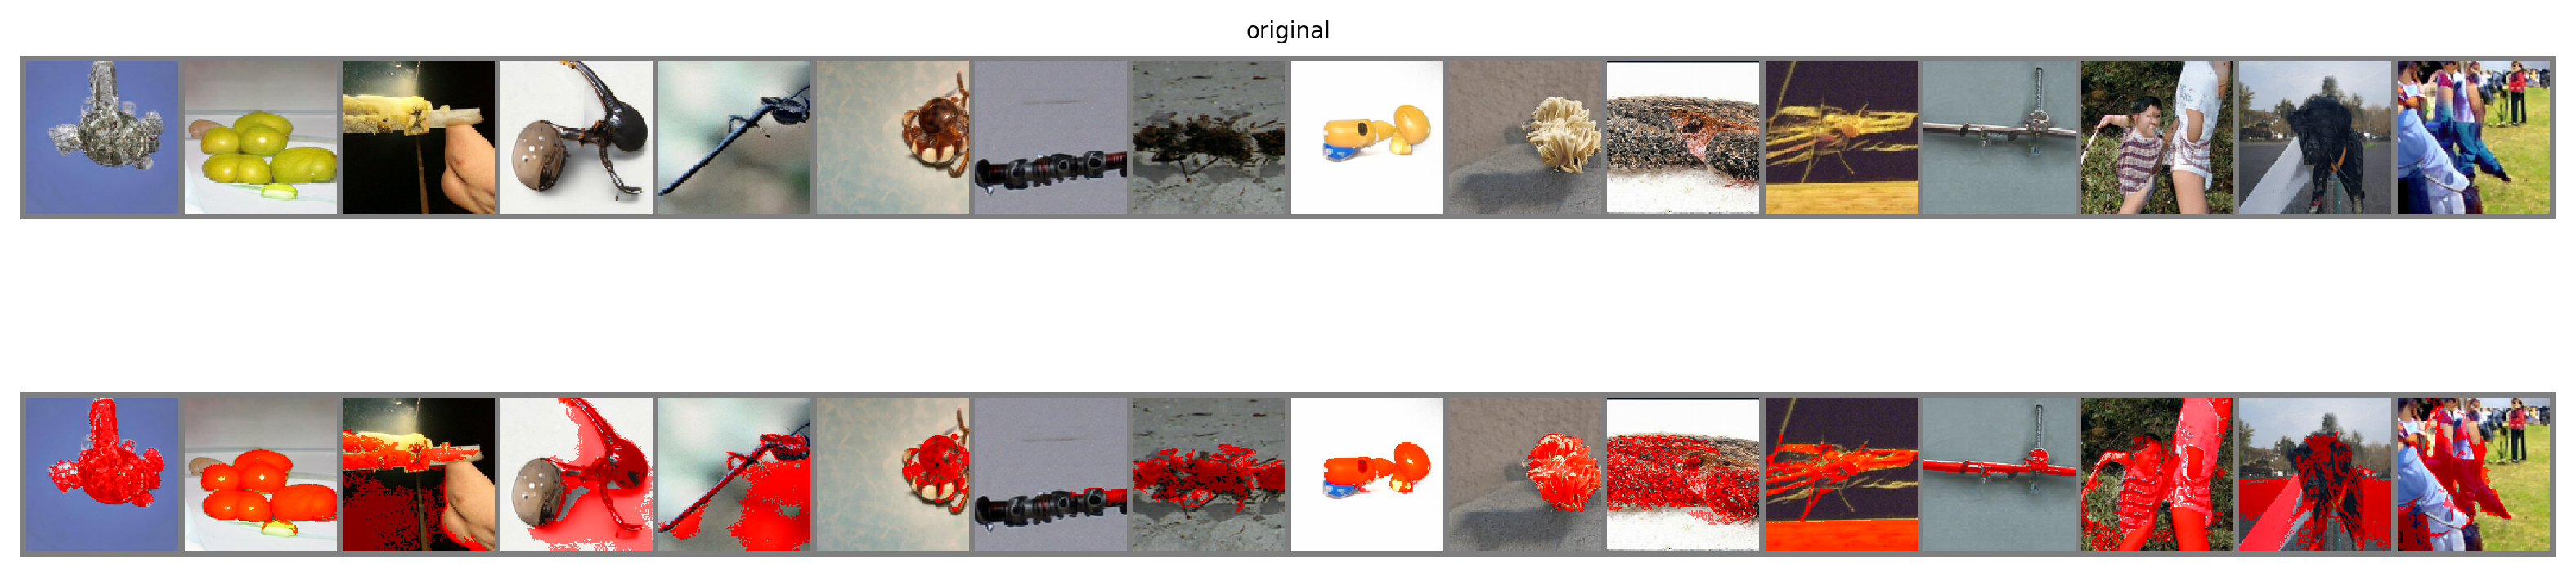

In [3]:
params = SegmentationTrainParams(batch_size=16, synthezing=MaskSynthesizing.LIGHTING,)

# z = torch.randn([params.batch_size, G.dim_z]).cuda()
z = torch.from_numpy(np.load('embeddings/BigBiGAN_ImageNet_z.npy')).cuda()[0:30]
mg = MaskGenerator(G, bg_direction, params, mask_postprocessing=(connected_components_filter,))
mg.cuda()

img, ref = mg(z=z)
draw_with_mask(img, [ref.unsqueeze(1)], names=[''], horizontal=False);

# Evaluation

In [11]:
from random import randint
from UNet.unet_model import UNet
from data import SegmentationDataset
from postprocessing import SegmentationInference, Threshold
from metrics import F_max, IoU, accuracy, model_metrics
from visualization import overlayed


unet = UNet().cuda().eval()
unet.load_state_dict(torch.load('pretrained/u_net_imagenet.pth', map_location='cpu'))
unet.cuda().eval();


batch_size = 1
ECSSD_imgs_dir = '__path_to_ECSSD_images__'
ECSSD_masks_dir = '__path_to_ECSSD_masks__'
target_ds = SegmentationDataset(ECSSD_imgs_dir, ECSSD_masks_dir, crop=False, size=None)
segmentation_dl = torch.utils.data.DataLoader(target_ds, batch_size, shuffle=False)

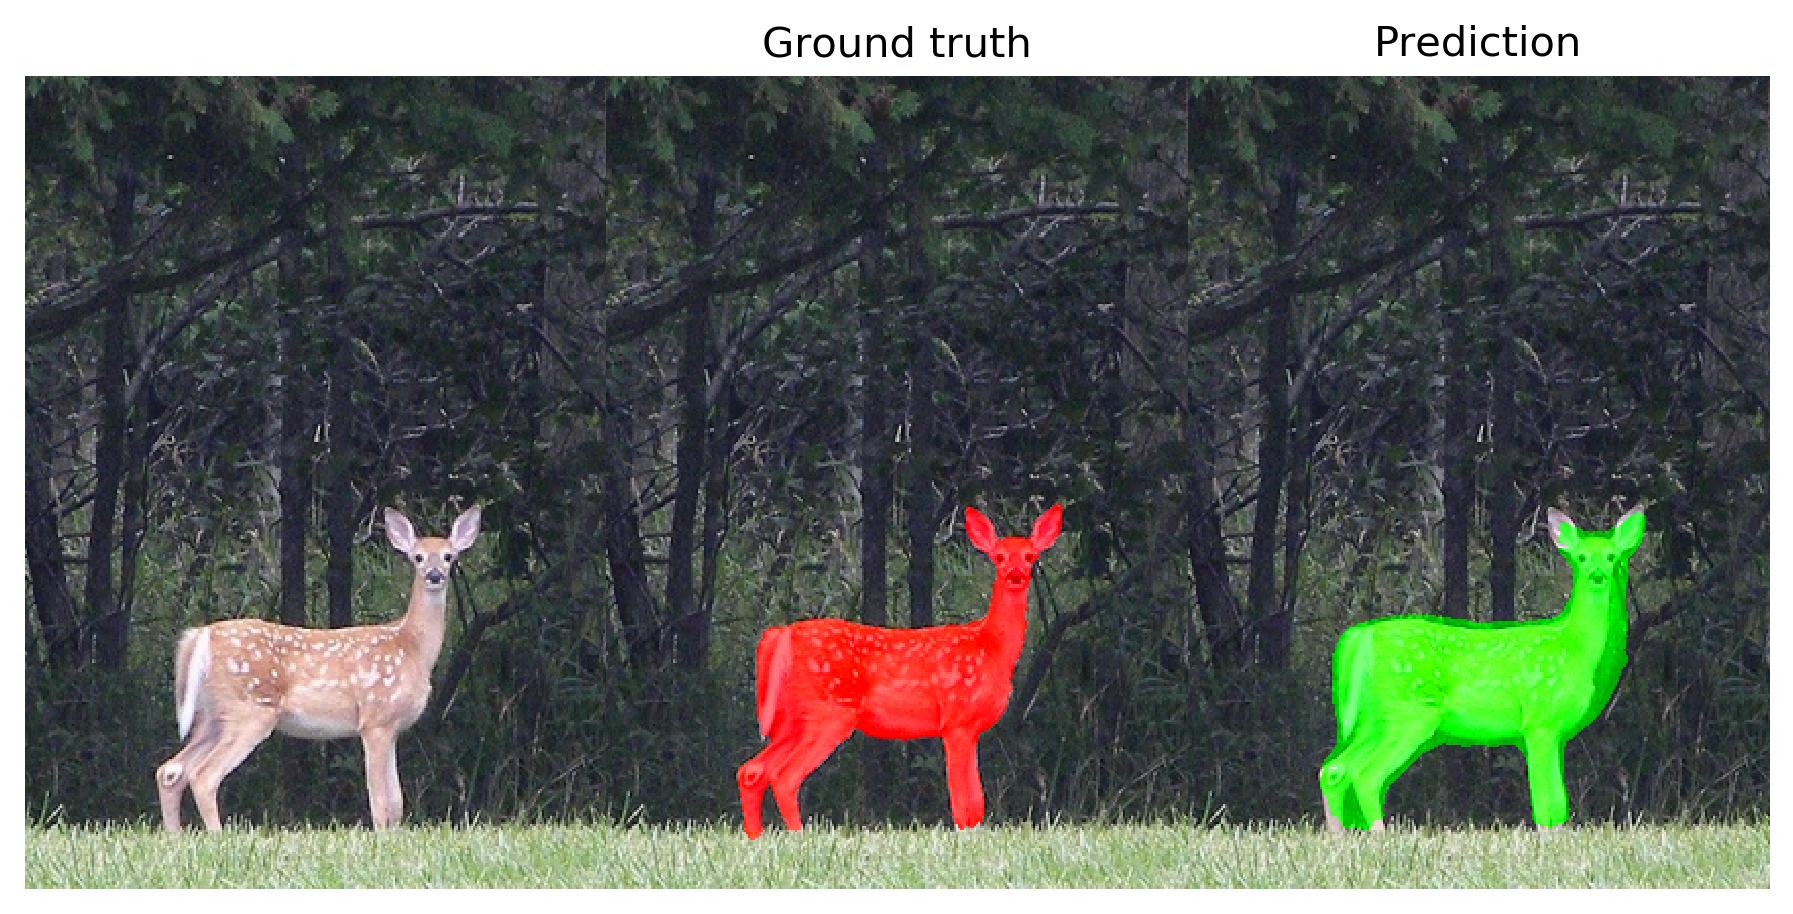

In [18]:
with torch.no_grad():
    img, mask = target_ds[randint(0, len(target_ds))]
    img, mask = img.cuda().unsqueeze(0), mask.cuda().unsqueeze(0)
    mask_prediction = SegmentationInference(unet, resize_to=128)(img) > 0.5


imgs_grid = make_grid(torch.clamp(img, -1, 1), nrow=batch_size, padding=5)
plt.figure(figsize=(9, 15.), dpi=250)

plt.subplot(131)
plt.axis('off')
plt.imshow(to_image(imgs_grid, True))
plt.subplot(132)
plt.axis('off')
plt.title('Ground truth')
plt.imshow(to_image(overlayed(img, mask, channel=0), True))
plt.subplot(133)
plt.axis('off')
plt.title('Prediction')
plt.imshow(to_image(overlayed(img, mask_prediction), True))

plt.subplots_adjust(wspace=0, hspace=0)

In [19]:
print('Raw model:\n{}'.format(
    model_metrics(SegmentationInference(unet, resize_to=128), segmentation_dl, stats=(F_max,))))
print('Thresholded:\n{}'.format(
    model_metrics(Threshold(unet, thr=0.5, resize_to=128), segmentation_dl, stats=(IoU, accuracy))))

Raw model:
{'F_max': 0.801901638507843}
Thresholded:
{'IoU': 0.683503343314107, 'accuracy': 0.9083143638074398}
